# Import Packages 

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
import random

# Mount Google Drive and Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# you might need to edit your file paths. Can copy file path by right clicking on file in sidebar
part1 = pd.read_csv('/content/drive/MyDrive/features_and_labels_0_100.csv')
part2 = pd.read_csv('/content/drive/MyDrive/features_and_labels_100_200.csv')
part3 = pd.read_csv('/content/drive/MyDrive/features_and_labels_200_309.csv')
part1.head()

,stimulus_presentations_id,1086530082,1086530578,1086530660,1086531242,1086531726,1086531924,1086532259,1086532531,1086532955,1086533303,1086533733,1086534118,1086534371,1086534822,1086535190,1086535548,1086535578,1086536044,1086536929,1086537159,1086537467,1086537706,1086538306,1086538443,1086538526,1086538821,1086539218,1086539784,1086539988,1086541212,1086541295,1086541490,1086541720,1086542048,1086542201,1086542362,1086542561,1086543097,1086543267,...,1086549857,1086550304,1086550430,1086550569,1086550822,1086551036,1086551875,1086552583,1086560788,1086562704,1086563029,1086563500,1086563771,1086563970,1086565183,1086565807,1086566089,1086566265,1086567264,1086567634,1086567920,1086568677,1086568825,1086569628,1086570008,1086570188,1086570312,1086583476,1086591506,1086591642,1086591841,1086591900,1086592285,1086592405,1086592431,1086592659,image_index,omitted,is_change,repeat_number
0,0,0.060545,0.027521,0.026000,-0.048008,-0.036040,0.007088,0.056185,0.005106,-0.004021,0.015221,0.070146,0.079935,-0.032045,-0.109714,-0.028251,0.330575,0.021831,0.061146,0.017890,0.031276,0.074626,0.001993,-0.016504,-0.034624,0.008669,0.030292,0.057225,0.022462,0.075993,-0.040012,0.012923,0.008473,0.049224,-0.034389,-0.011188,-0.017721,0.017030,0.118462,0.018346,...,0.022191,0.002053,0.031861,-0.016634,0.065343,0.017743,0.040982,0.068451,0.087563,0.028369,0.041550,0.017592,0.025262,0.094917,0.020860,0.094680,0.037506,0.024510,-0.023028,0.053854,-0.035373,0.014949,-0.061194,0.082706,-0.007602,-0.021826,0.045002,0.086943,0.065105,0.049013,0.003445,-0.000636,0.021111,0.030142,-0.018663,0.067360,0,False,False,NaN
1,1,-0.042837,0.005559,0.014897,-0.062901,0.025385,0.016963,0.070096,0.023723,-0.003728,0.011210,-0.024586,0.068342,-0.009259,-0.036900,0.046932,0.387255,0.017559,0.050382,0.032844,-0.026781,0.003553,0.018373,-0.002215,0.012686,-0.040877,-0.014755,0.033113,-0.057686,0.006831,0.000933,0.013033,0.022992,0.071800,0.016466,0.004840,-0.006439,-0.013042,0.003831,0.033636,...,-0.008344,-0.011099,-0.000424,0.025178,0.093657,0.243774,-0.031712,-0.004458,-0.062210,-0.002706,0.109223,-0.007905,-0.031032,-0.028525,0.017736,0.025363,0.013099,0.033520,0.051290,-0.006258,0.023347,-0.012978,0.048596,0.007491,-0.003645,0.073712,-0.027182,0.015705,0.046437,-0.003013,0.018261,0.060122,0.052270,-0.027252,0.014743,0.042195,0,False,False,NaN
2,2,0.045594,0.009826,0.017228,-0.017079,0.036537,-0.055258,-0.019113,0.035499,0.049114,-0.018874,-0.021714,-0.091088,0.047542,-0.014530,0.056814,0.291956,-0.018369,-0.060300,-0.010114,0.035194,0.011610,0.077002,0.043520,0.064978,0.030700,-0.009472,-0.006835,0.008504,-0.019133,0.005426,0.035042,-0.020946,0.011662,0.036484,0.019160,-0.018398,0.024914,0.000533,-0.000165,...,-0.007558,0.059134,-0.014061,-0.109299,0.061400,0.237702,-0.032981,-0.011613,-0.016226,-0.035027,0.071877,0.027375,-0.025508,0.004246,-0.057656,-0.000662,0.027978,-0.019437,-0.034709,-0.037976,0.010985,0.038856,0.036679,-0.015105,0.018100,0.057147,0.050270,-0.063645,0.030163,-0.006220,-0.032894,-0.060964,-0.052096,-0.022774,-0.016754,-0.054498,0,False,False,NaN
3,3,0.052346,-0.039637,-0.017558,0.027815,-0.050476,-0.020798,-0.010123,-0.069637,0.033699,0.008988,0.099772,-0.107686,-0.027187,-0.058461,-0.021830,0.051437,-0.058311,-0.036207,0.010184,0.025075,-0.014059,-0.033179,-0.034458,-0.016747,-0.115207,0.032573,0.009692,0.029525,0.025684,-0.035004,-0.006323,0.059971,-0.052356,-0.010229,-0.055244,-0.006790,0.001066,-0.000443,-0.006142,...,0.006909,-0.007673,-0.000305,-0.005911,-0.044531,0.151715,0.050913,0.037345,-0.013666,0.040027,-0.007727,-0.033943,0.017266,-0.011181,-0.025370,-0.037684,0.007323,0.002051,0.036950,-0.010595,-0.003147,-0.006976,-0.005927,-0.047134,-0.020600,-0.025232,-0.023600,0.038653,-0.012862,0.073038,-0.011484,0.017088,0.008877,-0.014259,0.027413,0.021970,0,False,False,NaN
4,4,-0.057092,0.040963,-0.008269,-0.004990,-0.032799,0.016353,-0.026384,0.023193,-0.045447,0.031888,-0.067595,0.045334,-0.035840,-0.027657,-0.029245,-0.056848,0.07

# Merge all three dataframes into one

In [ ]:
all = part1.merge(part2, how = 'inner', on = 'stimulus_presentations_id').merge(part3, how = 'inner', on = 'stimulus_presentations_id')

all.head()

all.columns

all.reset_index(inplace = True)

all

,index,stimulus_presentations_id,1086530082,1086530578,1086530660,1086531242,1086531726,1086531924,1086532259,1086532531,1086532955,1086533303,1086533733,1086534118,1086534371,1086534822,1086535190,1086535548,1086535578,1086536044,1086536929,1086537159,1086537467,1086537706,1086538306,1086538443,1086538526,1086538821,1086539218,1086539784,1086539988,1086541212,1086541295,1086541490,1086541720,1086542048,1086542201,1086542362,1086542561,1086543097,...,1086544292,1086544734,1086544936,1086545345,1086545725,1086545871,1086546050,1086546285,1086546496,1086547240,1086547714,1086553453,1086553567,1086553649,1086554491,1086557988,1086558140,1086558215,1086558459,1086558718,1086558870,1086559054,1086559461,1086559537,1086559673,1086559755,1086560413,1086560979,1086561239,1086561290,1086561368,1086561650,1086574732,1086574755,1086574886,1086574946,image_index,omitted,is_change,repeat_number
0,0,0,0.060545,0.027521,0.026000,-0.048008,-0.036040,0.007088,0.056185,0.005106,-0.004021,0.015221,0.070146,0.079935,-0.032045,-0.109714,-0.028251,0.330575,0.021831,0.061146,0.017890,0.031276,0.074626,0.001993,-0.016504,-0.034624,0.008669,0.030292,0.057225,0.022462,0.075993,-0.040012,0.012923,0.008473,0.049224,-0.034389,-0.011188,-0.017721,0.017030,0.118462,...,0.016860,0.002319,0.003482,-0.022813,0.052888,-0.017901,0.017415,0.011757,-0.011414,0.062848,-0.033253,0.035310,0.022060,0.028322,0.046027,0.026340,-0.041474,0.047693,-0.002553,-0.021364,0.073576,-0.034406,-0.005147,-0.021267,0.026992,0.061815,0.068429,-0.005572,0.010010,-0.069067,0.014622,0.039652,0.072262,-0.022477,0.028222,0.053899,0,False,False,NaN
1,1,1,-0.042837,0.005559,0.014897,-0.062901,0.025385,0.016963,0.070096,0.023723,-0.003728,0.011210,-0.024586,0.068342,-0.009259,-0.036900,0.046932,0.387255,0.017559,0.050382,0.032844,-0.026781,0.003553,0.018373,-0.002215,0.012686,-0.040877,-0.014755,0.033113,-0.057686,0.006831,0.000933,0.013033,0.022992,0.071800,0.016466,0.004840,-0.006439,-0.013042,0.003831,...,0.009363,-0.018463,-0.000260,-0.024991,0.001998,-0.050621,0.029630,-0.011336,-0.028047,-0.013042,0.040994,-0.015154,0.065105,-0.002287,-0.014605,-0.058703,0.096894,0.001006,0.020192,0.011660,-0.034766,0.000045,-0.015071,0.025266,0.031668,0.029712,-0.025184,0.058214,-0.041592,-0.029712,-0.035907,0.022758,0.007517,-0.004063,-0.005097,-0.020901,0,False,False,NaN
2,2,2,0.045594,0.009826,0.017228,-0.017079,0.036537,-0.055258,-0.019113,0.035499,0.049114,-0.018874,-0.021714,-0.091088,0.047542,-0.014530,0.056814,0.291956,-0.018369,-0.060300,-0.010114,0.035194,0.011610,0.077002,0.043520,0.064978,0.030700,-0.009472,-0.006835,0.008504,-0.019133,0.005426,0.035042,-0.020946,0.011662,0.036484,0.019160,-0.018398,0.024914,0.000533,...,-0.016238,-0.043576,0.044224,0.011079,-0.009634,0.041163,-0.010740,0.041133,-0.021978,-0.056208,0.001013,0.046129,-0.010672,-0.012411,-0.035511,-0.055800,-0.022856,-0.007998,0.017266,-0.037501,-0.012414,0.031191,0.103391,0.025251,0.007198,0.001967,0.051027,0.053504,-0.039993,0.041423,-0.001642,-0.000220,0.012122,-0.011783,0.005791,0.018898,0,False,False,NaN
3,3,3,0.052346,-0.039637,-0.017558,0.027815,-0.050476,-0.020798,-0.010123,-0.069637,0.033699,0.008988,0.099772,-0.107686,-0.027187,-0.058461,-0.021830,0.051437,-0.058311,-0.036207,0.010184,0.025075,-0.014059,-0.033179,-0.034458,-0.016747,-0.115207,0.032573,0.009692,0.029525,0.025684,-0.035004,-0.006323,0.059971,-0.052356,-0.010229,-0.055244,-0.006790,0.001066,-0.000443,...,0.024735,-0.035874,-0.063639,-0.057209,-0.074330,0.045721,-0.045114,-0.019413,0.008470,0.045175,-0.012764,-0.046922,-0.010160,-0.006978,0.080759,0.031454,-0.055452,-0.005029,0.009802,-0.009472,-0.022596,-0.021052,-0.001989,-0.012947,-0.003561,-0.061394,-0.015406,-0.089842,0.008547,-0.013719,0.002366,-0.046729,-0.034476,-0.004806,0.024567,0.003435,0,False,False,NaN
4,4,4,-0.057092,0.040963,-0.008269,-0.004990,-0.032799,0.016353,-0.026384,0.023193,-0.045447,0.031888,-0.067595,0.045334,-0.035840,-0.027657,-0.029245,-0.056848,0.072170,0.020387,-0.012063,

In [ ]:
# find all neuron ids by finding column names that are numbers
neuron_ids = filter(lambda str: str.isnumeric(), all.columns)

#find all non-neuron ids by finding column names that are not numbers
non_neuron_columms = filter(lambda str: not str.isnumeric(), part1.columns) #take from part1 to avoid duplicate columns from merge 

neuron_ids = [neuron for neuron in neuron_ids]
non_neuron_columms = [col for col in non_neuron_columms]



In [ ]:
trials_to_keep = all[all.repeat_number.notnull()]
features = trials_to_keep[neuron_ids]

trials_to_keep.head()



,index,stimulus_presentations_id,1086530082,1086530578,1086530660,1086531242,1086531726,1086531924,1086532259,1086532531,1086532955,1086533303,1086533733,1086534118,1086534371,1086534822,1086535190,1086535548,1086535578,1086536044,1086536929,1086537159,1086537467,1086537706,1086538306,1086538443,1086538526,1086538821,1086539218,1086539784,1086539988,1086541212,1086541295,1086541490,1086541720,1086542048,1086542201,1086542362,1086542561,1086543097,...,1086544292,1086544734,1086544936,1086545345,1086545725,1086545871,1086546050,1086546285,1086546496,1086547240,1086547714,1086553453,1086553567,1086553649,1086554491,1086557988,1086558140,1086558215,1086558459,1086558718,1086558870,1086559054,1086559461,1086559537,1086559673,1086559755,1086560413,1086560979,1086561239,1086561290,1086561368,1086561650,1086574732,1086574755,1086574886,1086574946,image_index,omitted,is_change,repeat_number
21,21,21,0.011584,0.015301,0.043644,-0.056359,0.017109,0.036748,0.018589,0.096304,-0.022754,0.002619,-0.009309,-0.035495,-0.014672,0.082899,0.020891,-0.055721,-0.007622,0.560128,0.028232,-0.006240,-0.011678,-0.027812,0.047016,0.038823,0.010142,0.008454,-0.011723,0.023396,0.005029,-0.050312,0.012919,-0.031312,0.152240,0.005228,0.026068,-0.005140,0.024047,-0.027338,...,-0.043573,-0.076285,-0.024475,-0.037567,0.001219,-0.042200,-0.000754,0.037730,0.031329,0.046432,0.074425,0.015640,0.002059,0.039401,0.002860,-0.026537,-0.014221,-0.019372,-0.010851,-0.044483,0.011293,-0.041399,-0.035399,-0.030803,-0.016999,0.045664,-0.001550,0.019204,-0.036975,-0.020003,0.044090,-0.005909,0.048051,-0.021794,-0.020526,-0.025154,7,False,True,0.0
22,22,22,-0.023315,0.004385,0.019678,-0.040932,-0.009471,0.019907,0.045366,0.025124,0.010743,0.023401,0.040895,-0.009639,0.009945,-0.009784,-0.044710,0.010053,0.021952,0.770480,-0.002051,-0.006351,0.008412,-0.044685,-0.011260,-0.045360,0.032607,0.004845,0.032276,0.022098,0.119252,0.022840,0.032912,0.020207,0.008254,0.008689,-0.055275,-0.015623,0.033444,0.032757,...,0.017536,-0.043052,0.076238,0.011019,-0.004307,0.052306,0.003932,-0.046048,-0.013359,-0.029276,0.038879,-0.017605,-0.044232,-0.016910,0.012320,-0.029419,0.006690,0.024468,0.022298,0.008349,-0.026270,-0.020799,0.002493,0.044219,-0.102599,-0.001953,0.021638,0.054941,0.000838,-0.005025,0.016271,0.012855,-0.060104,0.014018,0.048951,0.018864,7,False,False,1.0
34,34,34,0.044296,-0.047077,0.020999,0.071388,0.035181,0.024409,-0.009403,-0.004534,0.014582,-0.008974,0.045693,-0.048960,-0.070639,0.975267,0.018378,-0.020759,0.066646,0.004517,-0.009714,-0.030678,0.094291,0.000303,-0.023394,-0.033621,-0.031982,-0.013801,0.005634,0.013304,-0.007667,-0.033313,-0.026745,-0.009374,-0.054172,-0.056070,-0.023757,-0.083409,-0.082541,0.044123,...,-0.036911,-0.020614,0.023451,0.000394,0.002414,-0.045434,-0.016558,-0.015999,0.040150,0.026360,-0.097773,0.043384,0.008978,0.017567,0.146789,-0.018660,0.112643,-0.030904,-0.011293,-0.021340,0.021123,-0.015605,0.030991,-0.022877,0.012282,0.004253,0.015827,0.059649,0.006627,-0.004192,-0.001988,-0.029018,0.012765,-0.011655,0.034853,0.001671,3,False,True,0.0
35,35,35,0.070224,0.103574,-0.032966,-0.060781,0.035986,-0.058693,0.020326,0.007278,-0.008629,-0.031453,0.012496,0.007430,0.074827,0.327174,0.001055,-0.018377,-0.001616,0.036043,-0.013492,0.052989,0.012285,-0.016687,0.024699,0.028302,0.034558,-0.024727,0.030808,0.032495,0.023284,0.014548,0.032077,-0.012804,-0.008301,-0.012939,0.010963,0.012047,0.082131,-0.000795,...,0.027865,0.017844,0.058737,-0.038465,0.044051,0.032642,-0.005705,-0.014702,0.066955,0.004457,-0.006626,-0.029564,0.074681,-0.007429,0.107079,0.037010,0.054125,-0.015101,-0.016431,0.073169,0.013739,-0.014332,-0.013738,-0.006613,0.098469,-0.066443,0.020479,-0.042976,0.003661,-0.006438,0.009300,-0.005029,-0.102394,0.021235,-0.014813,-0.086162,3,False,False,1.0
47,47,47,0.050466,-0.008832,0.026768,0.016938,0.012035,0.033674,0.019028,-0.009151,0.011220,0.005766,-0.012488,0.062491,0.030557,0.369647,-0.004101,0.002719,0.073685,-0.048040,-0.02326

#PCA time

In [ ]:
pca = PCA(n_components=2)
principal_compontents = pca.fit_transform(features)

principal_df = pd.DataFrame(data =principal_compontents
             , columns = ['principal component 1', 'principal component 2'])

len(principal_df)


678

In [ ]:
thing_to_plot = pd.concat([principal_df, trials_to_keep[['image_index']].reset_index(drop = True)], axis = 1)
thing_to_plot.head()



,principal component 1,principal component 2,image_index
0,0.328279,-0.104025,7
1,-0.093033,-0.160703,7
2,2.952382,3.542304,3
3,-0.628933,3.265695,3
4,0.120983,-0.105990,2


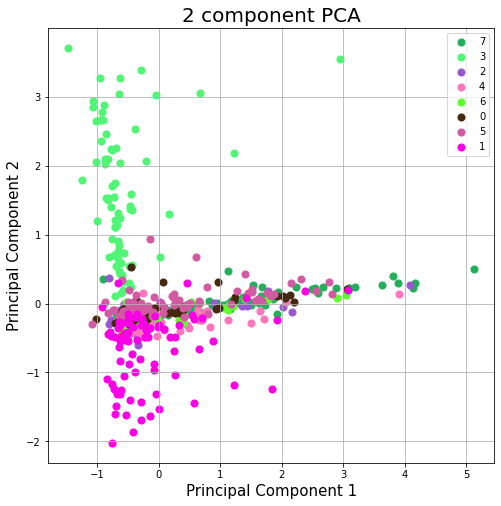

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = thing_to_plot.image_index.unique()
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(len(targets))]
for target, color in zip(targets,colors):
    indicesToKeep = thing_to_plot['image_index'] == target
    ax.scatter(thing_to_plot.loc[indicesToKeep, 'principal component 1']
               , thing_to_plot.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
pca.explained_variance_ratio_

array([0.24296247, 0.13725753])

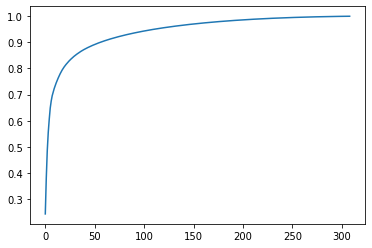

In [ ]:
pca_big = PCA()
principal_compontents = pca_big.fit_transform(features)
n_features = len(features.columns)

principal_df = pd.DataFrame(data =principal_compontents
             , columns = ['principal_component_{}'.format(i) for i in range(n_features)])

plt.plot(np.cumsum(pca_big.explained_variance_ratio_))

# Comparing the Adapted and Unadapted States


In [ ]:

unadapted = trials_to_keep[trials_to_keep.repeat_number == 0]
adapted = trials_to_keep[trials_to_keep.repeat_number == 1]

unadapted_features = unadapted[neuron_ids]
adapted_features = adapted[neuron_ids]



(0.0, 80.0)

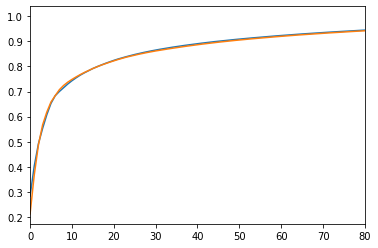

In [ ]:
adapted_pca = PCA()
unadapted_pca = PCA()

adapted_pcs = adapted_pca.fit_transform(adapted_features)
unadapted_pcs = unadapted_pca.fit_transform(unadapted_features)

plt.plot(np.cumsum(adapted_pca.explained_variance_ratio_))
plt.plot(np.cumsum(unadapted_pca.explained_variance_ratio_))

plt.xlim((0,80))



#Splitting By Area, Depth

Load cell ids from csv, and proccess

In [ ]:
cell_ids_by_structure = pd.read_csv('/content/drive/MyDrive/cell_ids_by_structure.csv')
cell_ids_by_structure.rename(columns = {'unique': 'cell_ids'}, inplace = True)


#for some reason, the list of cell ids got turned into a string. we make it back into a list
cell_ids_by_structure.cell_ids = cell_ids_by_structure.cell_ids.apply(lambda str: str[1:-1])
cell_ids_by_structure.cell_ids = cell_ids_by_structure.cell_ids.apply(lambda str: str.split())

cell_ids_by_structure.head()

,targeted_structure,imaging_depth,cell_ids
0,VISl,175,"[1086572844, 1086532820, 1086557138, 108653351..."
1,VISl,373,"[1086521589, 1086516055, 1086524224, 108653532..."
2,VISp,69,"[1086510515, 1086519287, 1086511438, 108651417..."
3,VISp,177,"[1086545315, 1086547736, 1086530578, 108653008..."
4,VISp,373,"[1086583476, 1086535578, 1086531041, 108654883..."


Split data frame of ETRs by structure

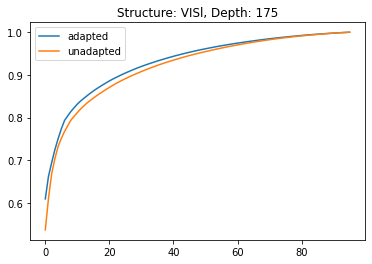

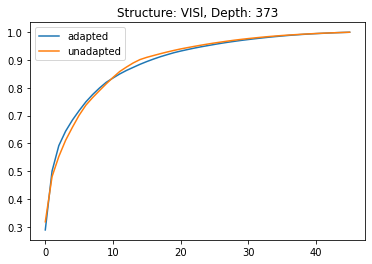

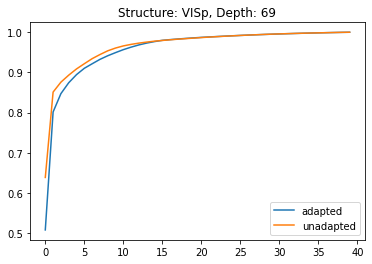

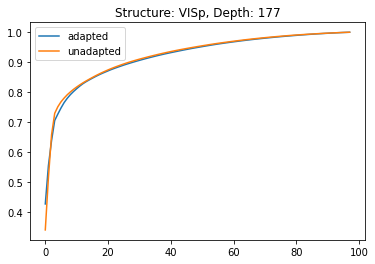

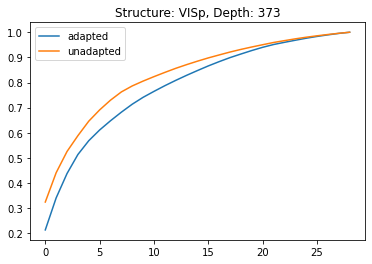

In [ ]:
for index, row in cell_ids_by_structure.iterrows():
  structure = row.targeted_structure
  depth = row.imaging_depth
  cell_ids_loc = row.cell_ids

  df = trials_to_keep[cell_ids_loc + non_neuron_columms]


  adapted = df[df.repeat_number == 0]
  unadapted = df[df.repeat_number == 1]

  adapted_features_loc = adapted[cell_ids_loc]
  unadapted_features_loc = unadapted[cell_ids_loc]

  adapted_pca_loc = PCA()
  unadapted_pca_loc = PCA()

  adapted_pcs_loc = adapted_pca_loc.fit_transform(adapted_features_loc)
  unadapted_pcs_loc = unadapted_pca_loc.fit_transform(unadapted_features_loc)


  plt.figure()
  plt.plot(np.cumsum(adapted_pca_loc.explained_variance_ratio_))
  plt.plot(np.cumsum(unadapted_pca_loc.explained_variance_ratio_))
  plt.title("Structure: {}, Depth: {}".format(structure, depth))
  plt.legend((["adapted", 'unadapted']))
  plt.savefig("{}{}_pca.png".format(structure, depth))





# Nonlinear dimension detection 

Here, we implement some methods to estimate the *underlying rank* of a matrix. The underlying rank of a matrix *A* is defined as the as the minimal rank *r* of a matrix *B* such that *A = f(B)*, where *f* is a monotone (order-preserving) function.  

A row-index *i* is a *minimal node* of *A* if *A[i,j]* is the smallest entry in the *j^th* column of *A*.  The expected number of minimal nodes of a random matrix increases as the underlying rank increases, thus counting the number of minimal nodes can be a useful tool for estimating underlying rank. 

In [ ]:
def n_min(A):
  mins = np.unique(np.argmin(A, axis = 1))
  return len(mins)

def n_min_curve(A): 
  m, n = A.shape
  return [n_min(A[np.random.choice(m, size = k, replace = False), :][:,np.random.choice(n, size = k, replace = False)]) for k in range(1,min(m,n)+1) ]

def mean_n_min_curve(A, samples = 20): 
  m, n = A.shape
  total = np.zeros((samples, min(m,n)))

  for i in range(samples):
    #print(i)
    total[i,:] = [n_min(A[np.random.choice(m, size = k, replace = False), :][:,np.random.choice(n, size = k, replace = False)]) for k in range(1,min(m,n)+1) ]

  return np.mean(total, axis = 0)



Example: comparing minimal nodes for rank 10 and rank 100 matrixes. 

rank A: 100
rank B: 10
rank C: 100


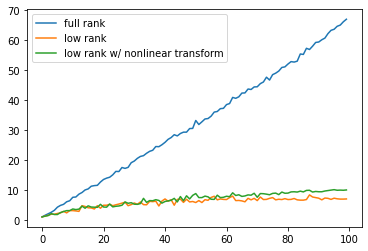

In [ ]:
A = np.random.rand(100,100)
U = np.random.rand(100,10)
B = U @U.T
C = np.log(B)**2
print("rank A: {}".format(np.linalg.matrix_rank(C)))
print("rank B: {}".format(np.linalg.matrix_rank(B)))
print("rank C: {}".format(np.linalg.matrix_rank(C)))

plt.plot(mean_n_min_curve(A))
plt.plot(mean_n_min_curve(B))
plt.plot(mean_n_min_curve(C))
plt.legend(["full rank", "low rank", "low rank w/ nonlinear transform"])

Comparing adapted and unadadapted states for all regions/depths. Both unadapted and adappted states look somewhat low rank, but they look very similar to one another. Both appear to be about rank 7 to rank 8. 

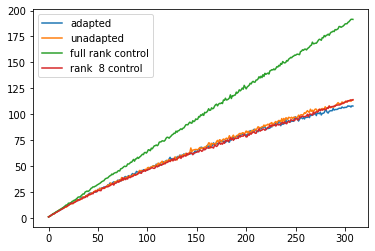

In [ ]:
k = 8
adapted_features_np = adapted_features.to_numpy()
unadapted_features_np = unadapted_features.to_numpy()

full_rank_control = np.random.rand(*adapted_features.shape)
U = np.random.rand(adapted_features.shape[0], k) - .5*np.ones((adapted_features.shape[0], k))
V = np.random.rand(k, adapted_features.shape[1]) - .5*np.ones((k, adapted_features.shape[1]))
low_rank_control = U@V

plt.plot(mean_n_min_curve(adapted_features_np))
plt.plot(mean_n_min_curve(unadapted_features_np))
plt.plot(mean_n_min_curve(full_rank_control))
plt.plot(mean_n_min_curve(low_rank_control))
plt.legend(["adapted", "unadapted", "full rank control", "rank  {} control".format(k)])




This is an interesting coincidence -- the rank of the data seems to match the number of images. 

Unfortunately, this appears to really just be a coincidence. When restricting to data from a smaller set of images, the rank remains 8. 

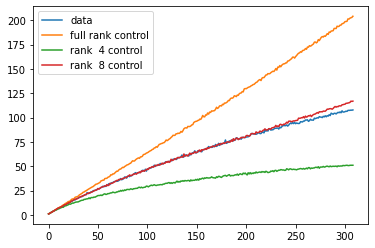

In [ ]:
k = 4
total_pics = 8
limited = trials_to_keep[trials_to_keep.image_index < k]
limited_features = limited[neuron_ids]
limited_features_np = limited_features.to_numpy()

full_rank_control = np.random.rand(*limited_features_np.shape)

U = np.random.rand(limited_features_np.shape[0], k) - .5*np.ones((limited_features_np.shape[0], k))
V = np.random.rand(k, limited_features_np.shape[1]) - .5*np.ones((k, limited_features_np.shape[1]))
low_rank_control = U@V

U = np.random.rand(limited_features_np.shape[0], total_pics) - .5*np.ones((limited_features_np.shape[0], total_pics))
V = np.random.rand(total_pics, limited_features_np.shape[1]) - .5*np.ones((total_pics, limited_features_np.shape[1]))
total_rank_control = U@V

plt.plot(mean_n_min_curve(limited_features_np, samples = 40))
plt.plot(mean_n_min_curve(full_rank_control, samples = 40))
plt.plot(mean_n_min_curve(low_rank_control, samples = 40))
plt.plot(mean_n_min_curve(total_rank_control, samples = 40))

plt.legend(["data", "full rank control", "rank  {} control".format(k), "rank  {} control".format(total_pics) ])


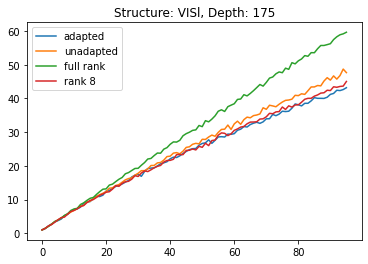

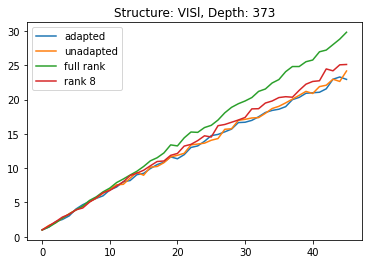

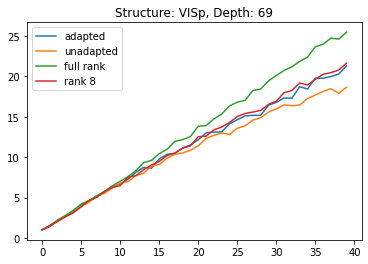

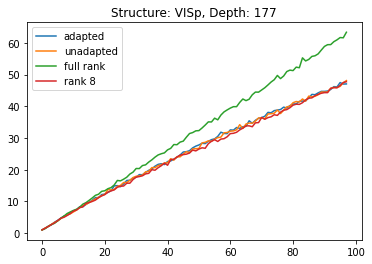

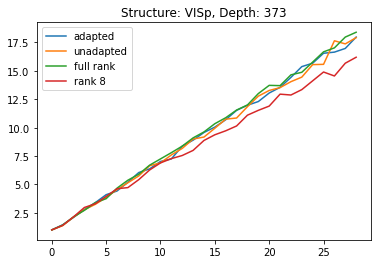

In [ ]:
k = 8
for index, row in cell_ids_by_structure.iterrows():
  structure = row.targeted_structure
  depth = row.imaging_depth
  cell_ids_loc= row.cell_ids

  df = trials_to_keep[cell_ids_loc + non_neuron_columms]

  adapted = df[df.repeat_number == 0]
  unadapted = df[df.repeat_number == 1]

  adapted_features_loc = adapted[cell_ids_loc]
  unadapted_features_loc = unadapted[cell_ids_loc]

  adapted_features_np = adapted_features_loc.to_numpy()
  unadapted_features_np = unadapted_features_loc.to_numpy() 
  full_rank_control = np.random.rand(*adapted_features_loc.shape)

  U = np.random.rand(adapted_features_np.shape[0], k) - .5*np.ones((adapted_features_np.shape[0], k))
  V = np.random.rand(k, adapted_features_np.shape[1]) - .5*np.ones((k, adapted_features_np.shape[1]))
  low_rank_control = U@V

  plt.figure()
  plt.plot(mean_n_min_curve(adapted_features_np, samples = 40))
  plt.plot(mean_n_min_curve(unadapted_features_np, samples = 40))
  plt.plot(mean_n_min_curve(full_rank_control, samples = 40))
  plt.plot(mean_n_min_curve(low_rank_control, samples = 40))

  plt.title("Structure: {}, Depth: {}".format(structure, depth))
  plt.legend((['adapted', 'unadapted', 'full rank', 'rank {}'.format(k)]))
  plt.savefig("{}{}_miniamal_nodes.png".format(structure, depth))


# Comparing average responses to stimuli across adapted and unadapted states

We compute the mean response to each image, separating out adapted and unadapted trials. 

In [ ]:
mean_responses = trials_to_keep.groupby(['image_index', 'repeat_number']).mean().reset_index()
mean_responses

,image_index,repeat_number,index,stimulus_presentations_id,1086530082,1086530578,1086530660,1086531242,1086531726,1086531924,1086532259,1086532531,1086532955,1086533303,1086533733,1086534118,1086534371,1086534822,1086535190,1086535548,1086535578,1086536044,1086536929,1086537159,1086537467,1086537706,1086538306,1086538443,1086538526,1086538821,1086539218,1086539784,1086539988,1086541212,1086541295,1086541490,1086541720,1086542048,1086542201,1086542362,...,1086543777,1086544145,1086544292,1086544734,1086544936,1086545345,1086545725,1086545871,1086546050,1086546285,1086546496,1086547240,1086547714,1086553453,1086553567,1086553649,1086554491,1086557988,1086558140,1086558215,1086558459,1086558718,1086558870,1086559054,1086559461,1086559537,1086559673,1086559755,1086560413,1086560979,1086561239,1086561290,1086561368,1086561650,1086574732,1086574755,1086574886,1086574946,omitted,is_change
0,0,0.0,2354.119048,2354.119048,0.013846,0.004827,0.006587,-0.003223,0.001460,0.025957,0.011436,0.002472,0.006551,0.007213,0.006258,0.032296,0.009377,0.173439,0.005511,0.092856,0.018049,0.058405,0.015418,-0.002108,0.011005,0.003086,0.008588,0.013271,0.026350,0.007469,0.007931,-0.003622,0.015128,0.008280,0.014669,0.007651,0.006163,0.005558,0.006521,0.002884,...,0.023736,0.008886,0.006230,0.008637,0.010060,-0.000489,-0.000082,-0.000940,0.005599,0.009389,-0.000660,0.004457,0.007461,-0.000623,0.004911,0.010435,0.003548,0.000136,0.026615,0.001116,0.005824,0.001612,0.010215,-0.004365,0.007603,0.008033,0.017567,0.009089,0.002428,0.014094,0.004457,0.004347,0.019059,0.007686,-0.002372,0.003370,0.002723,0.002534,False,True
1,0,1.0,2399.050000,2399.050000,0.027916,-0.004780,-0.005919,-0.000238,0.006458,-0.011313,-0.002783,0.000931,-0.008373,0.002826,0.012731,0.002723,-0.000782,-0.018647,-0.003211,0.102570,0.002176,0.001862,-0.000105,0.000929,-0.000461,-0.005960,-0.001388,0.004632,-0.008534,-0.005371,0.000763,0.002941,-0.004680,0.003107,-0.011184,0.007328,0.004549,0.001397,-0.007014,-0.006111,...,-0.008763,-0.004079,0.005045,0.016209,-0.006970,0.005980,-0.007133,-0.007592,-0.004214,-0.000488,0.003221,0.012839,0.001949,0.003491,0.002782,0.006161,-0.001186,0.007527,0.011738,-0.000203,-0.006778,0.008103,-0.003050,0.002214,-0.002672,-0.002341,0.008601,-0.000351,0.005897,0.001459,-0.000939,0.009363,-0.007850,0.006537,0.002930,-0.000571,0.004501,0.002210,False,False
2,1,0.0,2365.255814,2365.255814,0.004991,-0.002156,0.003795,0.003378,0.000604,0.001687,0.010428,0.014010,0.001094,0.010357,0.008381,0.020027,0.009621,0.258850,0.009078,0.017947,0.021077,0.009199,0.001521,0.003101,-0.000832,0.135242,0.004904,-0.001327,0.001759,0.007450,0.018781,0.001478,0.018787,-0.002203,0.000594,-0.007371,0.002862,0.011250,0.006192,0.010278,...,0.068499,0.005483,0.025206,0.004083,0.002269,0.008677,0.012016,-0.003242,0.004173,0.000760,0.007994,0.014066,0.011330,0.008632,-0.003108,0.008080,0.007581,0.002965,0.011621,0.001930,-0.002313,0.011108,0.008732,0.012864,0.007528,-0.001792,0.004841,0.006834,0.008185,0.011925,0.009026,0.000933,0.000973,0.040785,-0.000341,-0.003416,-0.005414,0.006592,False,True
3,1,1.0,2412.309524,2412.309524,-0.002507,0.005121,0.005518,0.006703,-0.004147,0.026581,-0.005349,-0.004792,-0.002298,0.002747,0.009905,-0.001782,0.001911,0.144027,-0.001366,-0.011593,0.023313,-0.015857,0.007471,0.006430,0.001699,0.118915,-0.002021,0.003464,-0.010947,-0.003050,0.005073,0.010908,0.021957,-0.001477,0.000642,-0.003325,0.011655,-0.004414,-0.004041,-0.003939,...,0.066517,-0.012858,0.007494,-0.004827,0.000319,-0.008741,0.008614,-0.001447,-0.001252,0.005959,-0.000732,0.000977,0.007144,-0.012998,-0.002019,0.003346,0.007773,0.001403,0.001178,0.006687,-0.005175,-0.002404,-0.003780,-0.004828,0.002403,0.005580,0.011688,-0.009863,0.001391,0.012802,0.008224,-0.001262,0.004944,0.006578,0.002672,0.006218,0.005631,-0.005111,False,False
4,2,0.0,2431.466667,2431.466667,0.015699,0.005385,0.009744,0.016616,0.005628,0.014183,0.015606,0.004528,0.010880,0.009308,0.007439,0.036404,0.013601,0.176154,0.0

Now, let's PCA on this--seems like there's not a huge dimension effect here eiter. 

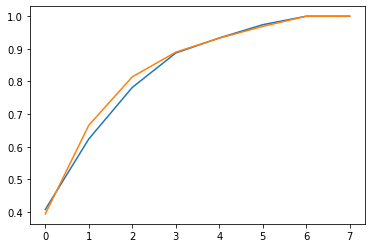

In [ ]:
mean_features = mean_responses[neuron_ids]
mean_adapted_features = mean_responses[mean_responses.repeat_number == 1][neuron_ids]
mean_unadapted_features = mean_responses[mean_responses.repeat_number == 0][neuron_ids]

mean_adapted_pca = PCA()
mean_unadapted_pca = PCA()

mean_adapted_pcs = mean_adapted_pca.fit_transform(mean_adapted_features)
mean_nadapted_pcs = mean_unadapted_pca.fit_transform(mean_unadapted_features)

plt.plot(np.cumsum(mean_adapted_pca.explained_variance_ratio_))
plt.plot(np.cumsum(mean_unadapted_pca.explained_variance_ratio_))



Similarly, nonlinear dimension detection using minimal nodes indicates that the mean responses use their whole space, in all structures. 

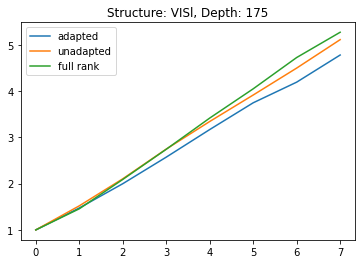

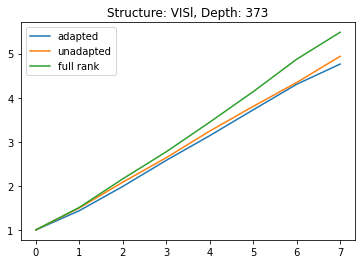

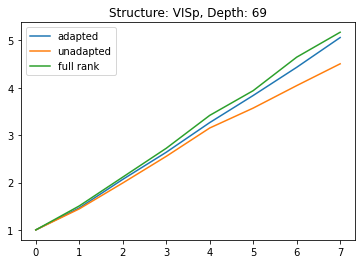

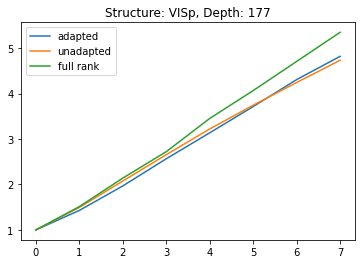

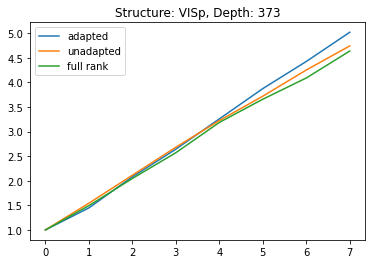

In [ ]:

for index, row in cell_ids_by_structure.iterrows():
  structure = row.targeted_structure
  depth = row.imaging_depth
  cell_ids_loc= row.cell_ids

  df = mean_responses[cell_ids_loc + non_neuron_columms]

  adapted = df[df.repeat_number == 0]
  unadapted = df[df.repeat_number == 1]

  adapted_features_loc = adapted[cell_ids_loc]
  unadapted_features_loc = unadapted[cell_ids_loc]

  adapted_features_np = adapted_features_loc.to_numpy()
  unadapted_features_np = unadapted_features_loc.to_numpy() 
  full_rank_control = np.random.rand(*adapted_features_loc.shape)

  plt.figure()
  plt.plot(mean_n_min_curve(adapted_features_np, samples = 500))
  plt.plot(mean_n_min_curve(unadapted_features_np, samples = 500))
  plt.plot(mean_n_min_curve(full_rank_control, samples = 500))

  plt.title("Structure: {}, Depth: {}".format(structure, depth))
  plt.legend((['adapted', 'unadapted', 'full rank']))
  plt.savefig("{}{}_miniamal_nodes.png".format(structure, depth))

# Visual Comparison of Adapted and Unadapted State

We use PCA to plot the mean response to each image in the adapted and undatapted states, plot in the principal compontents of the adapted states. 

Mean adapted responses and unadapted responses to each image appear similar, and the change does not happen in a fiex direction. 

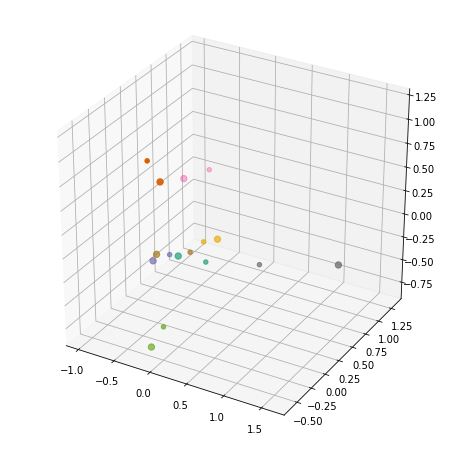

In [ ]:
mean_adapted_pca_small = PCA(n_components= 3)
mean_unadapted_pca_small = PCA(n_components = 3)

#fit PCA based on adapted data
mean_adapted_pcs_small = mean_adapted_pca_small.fit_transform(mean_adapted_features)

#transform all data based on this fit 
principal_pcs = mean_adapted_pca_small.transform(mean_features)

#put the labels (image index and repeat number) back for plotting
principal_df = pd.DataFrame(data =principal_pcs
             , columns = ['pc1', 'pc2', 'pc3'])
principal_df = pd.concat([principal_df, mean_responses[['image_index', 'repeat_number']]], axis = 1)



fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(principal_df.pc1, principal_df.pc2, principal_df.pc3, c = principal_df.image_index, cmap = 'Dark2', s = 20 + 20*principal_df.repeat_number )


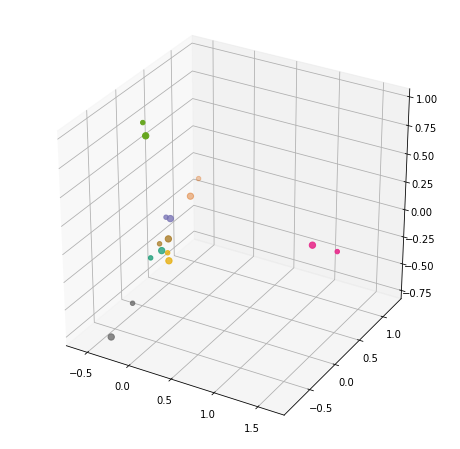

In [ ]:
#mean_adapted_pca_small = PCA(n_components= 3)
mean_unadapted_pca_small = PCA(n_components = 3)

#fit PCA based on adapted data
mean_unadapted_pcs_small = mean_unadapted_pca_small.fit_transform(mean_unadapted_features)

#transform all data based on this fit 
principal_pcs = mean_unadapted_pca_small.transform(mean_features)

#put the labels (image index and repeat number) back for plotting
principal_df = pd.DataFrame(data =principal_pcs
             , columns = ['pc1', 'pc2', 'pc3'])
principal_df = pd.concat([principal_df, mean_responses[['image_index', 'repeat_number']]], axis = 1)


fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(principal_df.pc1, principal_df.pc2, principal_df.pc3, c = principal_df.image_index, cmap = 'Dark2', s = 20 + 20*principal_df.repeat_number )


Now, let's project all responses into the space of mean adapted responses, and color in the same way. 

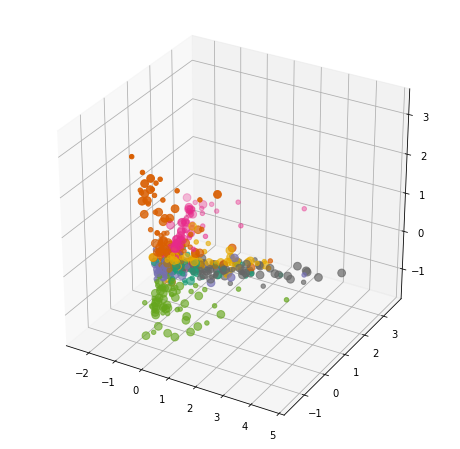

In [ ]:

#transform all data based on this fit 
principal_pcs = mean_adapted_pca_small.transform(features)

#put the labels (image index and repeat number) back for plotting
principal_df = pd.DataFrame(data =principal_pcs
             , columns = ['pc1', 'pc2', 'pc3'])
principal_df = pd.concat([principal_df, trials_to_keep[['image_index', 'repeat_number']].reset_index()], axis = 1)



fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(principal_df.pc1, principal_df.pc2, principal_df.pc3, c = principal_df.image_index, cmap = 'Dark2', s = 20 + 40*principal_df.repeat_number )
#ax.view_init(60, 30) 

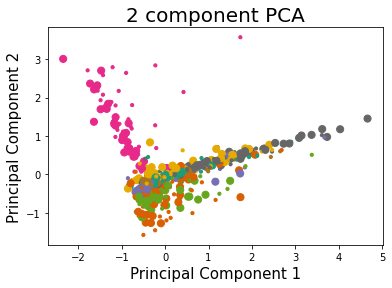

In [ ]:

#transform all data based on this fit 
principal_pcs = mean_adapted_pca_small.transform(features)

#put the labels (image index and repeat number) back for plotting
principal_df = pd.DataFrame(data =principal_pcs[:,0:2]
             , columns = ['pc1', 'pc2'])
principal_df = pd.concat([principal_df, trials_to_keep[['image_index', 'repeat_number']].reset_index()], axis = 1)


#plot
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('2 component PCA', fontsize = 20)
plt.scatter(principal_df.pc1, principal_df.pc2, c = principal_df.image_index, cmap = 'Dark2', s = 10 + 40*principal_df.repeat_number)

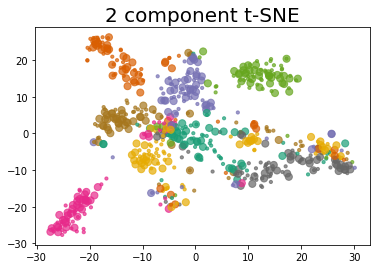

In [ ]:
all_tsne = TSNE(n_components=2, init='random',
                         random_state=0, perplexity=30)
 
tsne_fit = all_tsne.fit_transform(features)
 

#put the labels (image index and repeat number) back for plotting
tsne_df = pd.DataFrame(data =tsne_fit
             , columns = ['comp1', 'comp2'])
tsne_df = pd.concat([tsne_df, trials_to_keep[['image_index', 'repeat_number']].reset_index()], axis = 1)


#plot
plt.title('2 component t-SNE', fontsize = 20)
plt.scatter(tsne_df.comp1, tsne_df.comp2, c = tsne_df.image_index, cmap = 'Dark2', s = 10 + 40*principal_df.repeat_number, alpha = 0.7)

In [ ]:

unadapted = trials_to_keep[trials_to_keep.repeat_number == 0]
adapted = trials_to_keep[trials_to_keep.repeat_number == 1]

unadapted_features = unadapted[neuron_ids]
adapted_features = adapted[neuron_ids]


In [ ]:

adapted_tsne = TSNE(n_components=2, init='random',
                         random_state=0, perplexity=30, n_iter = 3000)


tsne_fit = adapted_tsne.fit_transform(adapted_features)

#put the labels (image index and repeat number) back for plotting
tsne_df = pd.DataFrame(data =tsne_fit
             , columns = ['comp1', 'comp2'])


tsne_df = pd.concat([tsne_df, adapted[['image_index', 'repeat_number']].reset_index()], axis = 1)

In [ ]:
unadapted_tsne = TSNE(n_components=2, init='random',
                         random_state=0, perplexity=30, n_iter = 3000)


u_tsne_fit = unadapted_tsne.fit_transform(unadapted_features)

#put the labels (image index and repeat number) back for plotting
u_tsne_df = pd.DataFrame(data =u_tsne_fit
               , columns = ['comp1', 'comp2'])


u_tsne_df = pd.concat([u_tsne_df, unadapted[['image_index', 'repeat_number']].reset_index()], axis = 1)

0.5273140668869019


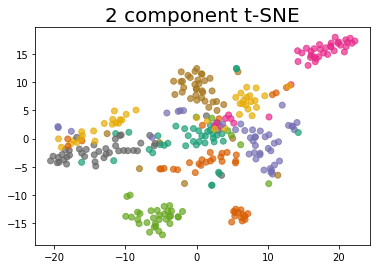

In [ ]:

#plot
plt.title('2 component t-SNE', fontsize = 20)
plt.scatter(tsne_df.comp1, tsne_df.comp2, c = tsne_df.image_index, cmap = 'Dark2', alpha = 0.7)

print(adapted_tsne.kl_divergence_)

0.711681604385376


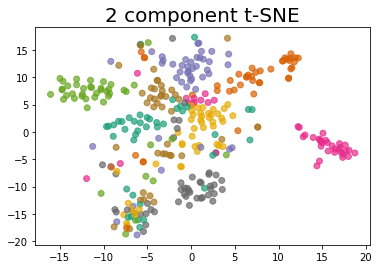

In [ ]:
#plot
plt.title('2 component t-SNE', fontsize = 20)
plt.scatter(u_tsne_df.comp1, u_tsne_df.comp2, c = u_tsne_df.image_index, cmap = 'Dark2', alpha = 0.7)

print(unadapted_tsne.kl_divergence_)

# Comparing neurons with different adaptation magnitudes

First, we need to compute adaptation magnitude

In [ ]:
#compute mean response for each cell across adapted and unadapted states 

mean_responses = trials_to_keep.groupby(['repeat_number']).mean().reset_index()
print(mean_responses.head())

mean_responses_np = mean_responses[neuron_ids].to_numpy()

adaptation_magnitude = (mean_responses_np[0,:] - mean_responses_np[1,:])/mean_responses_np[0,:]


adaptation_magnitude_df = pd.DataFrame(data = adaptation_magnitude, columns = ['adaptation_magnitude'])
adaptation_magnitude_df['neuron_id'] = neuron_ids
adaptation_magnitude_df['abs_adaptation'] = adaptation_magnitude_df.adaptation_magnitude.apply(abs)

adaptation_magnitude_df.head()



   repeat_number        index  ...  omitted  is_change
0            0.0  2407.822857  ...    False       True
1            1.0  2381.673780  ...    False      False

[2 rows x 323 columns]


,adaptation_magnitude,neuron_id,abs_adaptation
0,0.455068,1086530082,0.455068
1,0.726976,1086530578,0.726976
2,0.355668,1086530660,0.355668
3,0.944757,1086531242,0.944757
4,-4.921060,1086531726,4.921060


In [ ]:
adaptation_magnitude_df.describe()

,adaptation_magnitude,abs_adaptation
count,309.000000,309.000000
mean,0.371242,0.792274
std,1.633543,1.475464
min,-20.227014,0.000064
25%,0.301112,0.364379
50%,0.598658,0.651312
75%,0.850265,0.874487
max,1.646802,20.227014


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

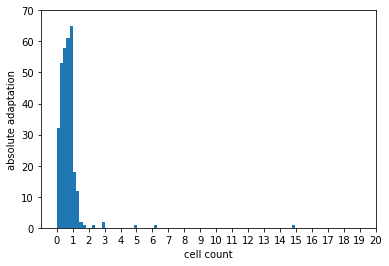

In [ ]:
plt.hist(adaptation_magnitude_df.abs_adaptation, bins = 100);
plt.xticks((np.arange(0,20.1,1)));
plt.xlim(-1,20)
plt.ylim(0,70);
plt.xlabel('cell count')
plt.ylabel('absolute adaptation')

figtitle = 'distribution of absolute adaptation'
plt.savefig(figtitle + '.pdf', format='pdf')
from google.colab import files
files.download(figtitle + '.pdf')

abs adp is mostly reasonable - grating & bunny7 dataset has abs adp within 3


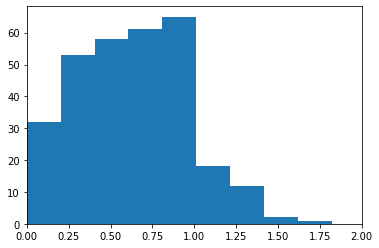

In [ ]:
plt.hist(adaptation_magnitude_df.abs_adaptation, bins = 100)
# plt.title("abs adaptation")
plt.xlim(0,2)
print("abs adp is mostly reasonable - grating & bunny7 dataset has abs adp within 3")

## Discard neurons with abs_adp > 2  
the effect is obvious even if you discard abs_adp > 1 (a very strict rule)

In [ ]:
adaptation_magnitude_df = adaptation_magnitude_df[adaptation_magnitude_df.abs_adaptation <= 2]
adaptation_magnitude_df.describe()

,adaptation_magnitude,abs_adaptation
count,302.000000,302.000000
mean,0.559391,0.631095
std,0.439083,0.327333
min,-1.234256,0.000064
25%,0.317611,0.360925
50%,0.615717,0.638009
75%,0.854946,0.865379
max,1.646802,1.646802


## Use full data

Now, we split the neurons by whether adaptation magnitude is above or below the mean. 

Mean adaptation magnitude:  0.631095199461394


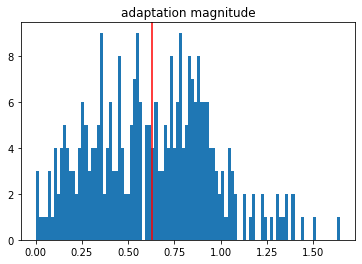

In [ ]:
plt.hist(adaptation_magnitude_df.abs_adaptation, bins = 100)
plt.title("adaptation magnitude")
mean_adaptation = adaptation_magnitude_df.abs_adaptation.mean()
print("Mean adaptation magnitude: ", mean_adaptation)

adapted_cells = adaptation_magnitude_df[adaptation_magnitude_df.abs_adaptation > mean_adaptation ]
less_adapted_cells = adaptation_magnitude_df[adaptation_magnitude_df.abs_adaptation <= mean_adaptation ]

plt.axvline(mean_adaptation, color = 'red')

Now, let's compare dimension reduction on more and less adapted cells, divided by mean abs adp. (before and after adaptation?)

In [ ]:
trials_to_keep.head()

,index,stimulus_presentations_id,1086530082,1086530578,1086530660,1086531242,1086531726,1086531924,1086532259,1086532531,1086532955,1086533303,1086533733,1086534118,1086534371,1086534822,1086535190,1086535548,1086535578,1086536044,1086536929,1086537159,1086537467,1086537706,1086538306,1086538443,1086538526,1086538821,1086539218,1086539784,1086539988,1086541212,1086541295,1086541490,1086541720,1086542048,1086542201,1086542362,1086542561,1086543097,...,1086544292,1086544734,1086544936,1086545345,1086545725,1086545871,1086546050,1086546285,1086546496,1086547240,1086547714,1086553453,1086553567,1086553649,1086554491,1086557988,1086558140,1086558215,1086558459,1086558718,1086558870,1086559054,1086559461,1086559537,1086559673,1086559755,1086560413,1086560979,1086561239,1086561290,1086561368,1086561650,1086574732,1086574755,1086574886,1086574946,image_index,omitted,is_change,repeat_number
21,21,21,0.011584,0.015301,0.043644,-0.056359,0.017109,0.036748,0.018589,0.096304,-0.022754,0.002619,-0.009309,-0.035495,-0.014672,0.082899,0.020891,-0.055721,-0.007622,0.560128,0.028232,-0.006240,-0.011678,-0.027812,0.047016,0.038823,0.010142,0.008454,-0.011723,0.023396,0.005029,-0.050312,0.012919,-0.031312,0.152240,0.005228,0.026068,-0.005140,0.024047,-0.027338,...,-0.043573,-0.076285,-0.024475,-0.037567,0.001219,-0.042200,-0.000754,0.037730,0.031329,0.046432,0.074425,0.015640,0.002059,0.039401,0.002860,-0.026537,-0.014221,-0.019372,-0.010851,-0.044483,0.011293,-0.041399,-0.035399,-0.030803,-0.016999,0.045664,-0.001550,0.019204,-0.036975,-0.020003,0.044090,-0.005909,0.048051,-0.021794,-0.020526,-0.025154,7,False,True,0.0
22,22,22,-0.023315,0.004385,0.019678,-0.040932,-0.009471,0.019907,0.045366,0.025124,0.010743,0.023401,0.040895,-0.009639,0.009945,-0.009784,-0.044710,0.010053,0.021952,0.770480,-0.002051,-0.006351,0.008412,-0.044685,-0.011260,-0.045360,0.032607,0.004845,0.032276,0.022098,0.119252,0.022840,0.032912,0.020207,0.008254,0.008689,-0.055275,-0.015623,0.033444,0.032757,...,0.017536,-0.043052,0.076238,0.011019,-0.004307,0.052306,0.003932,-0.046048,-0.013359,-0.029276,0.038879,-0.017605,-0.044232,-0.016910,0.012320,-0.029419,0.006690,0.024468,0.022298,0.008349,-0.026270,-0.020799,0.002493,0.044219,-0.102599,-0.001953,0.021638,0.054941,0.000838,-0.005025,0.016271,0.012855,-0.060104,0.014018,0.048951,0.018864,7,False,False,1.0
34,34,34,0.044296,-0.047077,0.020999,0.071388,0.035181,0.024409,-0.009403,-0.004534,0.014582,-0.008974,0.045693,-0.048960,-0.070639,0.975267,0.018378,-0.020759,0.066646,0.004517,-0.009714,-0.030678,0.094291,0.000303,-0.023394,-0.033621,-0.031982,-0.013801,0.005634,0.013304,-0.007667,-0.033313,-0.026745,-0.009374,-0.054172,-0.056070,-0.023757,-0.083409,-0.082541,0.044123,...,-0.036911,-0.020614,0.023451,0.000394,0.002414,-0.045434,-0.016558,-0.015999,0.040150,0.026360,-0.097773,0.043384,0.008978,0.017567,0.146789,-0.018660,0.112643,-0.030904,-0.011293,-0.021340,0.021123,-0.015605,0.030991,-0.022877,0.012282,0.004253,0.015827,0.059649,0.006627,-0.004192,-0.001988,-0.029018,0.012765,-0.011655,0.034853,0.001671,3,False,True,0.0
35,35,35,0.070224,0.103574,-0.032966,-0.060781,0.035986,-0.058693,0.020326,0.007278,-0.008629,-0.031453,0.012496,0.007430,0.074827,0.327174,0.001055,-0.018377,-0.001616,0.036043,-0.013492,0.052989,0.012285,-0.016687,0.024699,0.028302,0.034558,-0.024727,0.030808,0.032495,0.023284,0.014548,0.032077,-0.012804,-0.008301,-0.012939,0.010963,0.012047,0.082131,-0.000795,...,0.027865,0.017844,0.058737,-0.038465,0.044051,0.032642,-0.005705,-0.014702,0.066955,0.004457,-0.006626,-0.029564,0.074681,-0.007429,0.107079,0.037010,0.054125,-0.015101,-0.016431,0.073169,0.013739,-0.014332,-0.013738,-0.006613,0.098469,-0.066443,0.020479,-0.042976,0.003661,-0.006438,0.009300,-0.005029,-0.102394,0.021235,-0.014813,-0.086162,3,False,False,1.0
47,47,47,0.050466,-0.008832,0.026768,0.016938,0.012035,0.033674,0.019028,-0.009151,0.011220,0.005766,-0.012488,0.062491,0.030557,0.369647,-0.004101,0.002719,0.073685,-0.048040,-0.02326

In [ ]:
adapting_cells_df = trials_to_keep[adapted_cells.neuron_id.tolist()+non_neuron_columms]
non_adapting_cells_df = trials_to_keep[less_adapted_cells.neuron_id.tolist() + non_neuron_columms]

adapting_cells_features = trials_to_keep[adapted_cells.neuron_id.tolist()]
non_adapting_cells_features = trials_to_keep[less_adapted_cells.neuron_id.tolist()]

In [ ]:

adapting_tsne = TSNE(n_components=2, init='random',
                         random_state=0, perplexity=30, n_iter = 3000)


adapting_tsne_fit = adapting_tsne.fit_transform(adapting_cells_features)

#put the labels (image index and repeat number) back for plotting
adapting_tsne_df = pd.DataFrame(data = adapting_tsne_fit
             , columns = ['comp1', 'comp2'])


adapting_tsne_df = pd.concat([adapting_tsne_df, adapting_cells_df[['image_index', 'repeat_number']].reset_index()], axis = 1)

1.8128246068954468


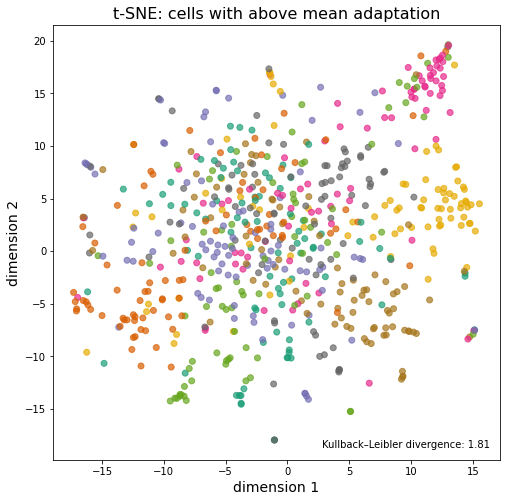

In [ ]:
from matplotlib.offsetbox import AnchoredText

fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(adapting_tsne_df.comp1, adapting_tsne_df.comp2, c = adapting_tsne_df.image_index, cmap = 'Dark2', alpha = 0.7)
plt.title('t-SNE: cells with above mean adaptation', fontsize = 16)
plt.xlabel('dimension 1', fontsize = 14)
plt.ylabel('dimension 2', fontsize = 14)

box_text = 'Kullback–Leibler divergence: ' + '{0:.2f}'.format(adapting_tsne.kl_divergence_)
text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='white', alpha=0.5);
ax.add_artist(text_box)

print(adapting_tsne.kl_divergence_)

In [ ]:

non_adapting_tsne = TSNE(n_components=2, init='random',
                         random_state=0, perplexity=30, n_iter = 3000)


non_adapting_tsne_fit = non_adapting_tsne.fit_transform(non_adapting_cells_features)

#put the labels (image index and repeat number) back for plotting
non_adapting_tsne_df = pd.DataFrame(data =non_adapting_tsne_fit
             , columns = ['comp1', 'comp2'])


non_adapting_tsne_df  = pd.concat([non_adapting_tsne_df , non_adapting_cells_df[['image_index', 'repeat_number']].reset_index()], axis = 1)

0.7152805328369141


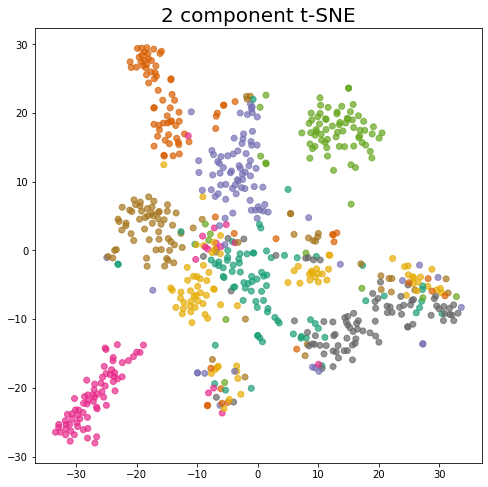

In [ ]:
#plot
plt.figure(figsize = (8,8))
plt.title('2 component t-SNE', fontsize = 20)
plt.scatter(non_adapting_tsne_df.comp1, non_adapting_tsne_df.comp2, c = non_adapting_tsne_df.image_index, cmap = 'Dark2', alpha = 0.7)

print(non_adapting_tsne.kl_divergence_)

### split by median

Now, we split the neurons by whether adaptation magnitude is above or below the median. 

Median adaptation magnitude:  0.6380086161047156


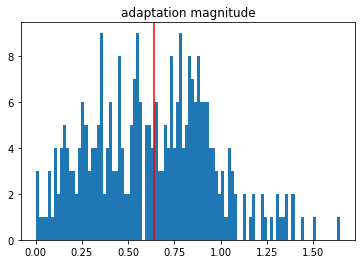

In [ ]:
plt.hist(adaptation_magnitude_df.abs_adaptation, bins = 100)
plt.title("adaptation magnitude")
median_adaptation = adaptation_magnitude_df.abs_adaptation.median()
print("Median adaptation magnitude: ", median_adaptation)

above_adapted_cells = adaptation_magnitude_df[adaptation_magnitude_df.abs_adaptation > median_adaptation ]
below_adapted_cells = adaptation_magnitude_df[adaptation_magnitude_df.abs_adaptation <= median_adaptation ]

plt.axvline(median_adaptation, color = 'red')

Now, let's compare dimension reduction on more and less adapted cells.

In [ ]:
above_cells_df = trials_to_keep[above_adapted_cells.neuron_id.tolist()+non_neuron_columms]
below_cells_df = trials_to_keep[below_adapted_cells.neuron_id.tolist() + non_neuron_columms]

above_cells_features = trials_to_keep[above_adapted_cells.neuron_id.tolist()]
below_cells_features = trials_to_keep[below_adapted_cells.neuron_id.tolist()]

In [ ]:

above_tsne = TSNE(n_components=2, init='random',
                         random_state=0, perplexity=30, n_iter = 3000)


above_tsne_fit = above_tsne.fit_transform(above_cells_features)

#put the labels (image index and repeat number) back for plotting
above_tsne_df = pd.DataFrame(data = above_tsne_fit
             , columns = ['comp1', 'comp2'])

above_tsne_df = pd.concat([above_tsne_df, above_cells_df[['image_index', 'repeat_number']].reset_index()], axis = 1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

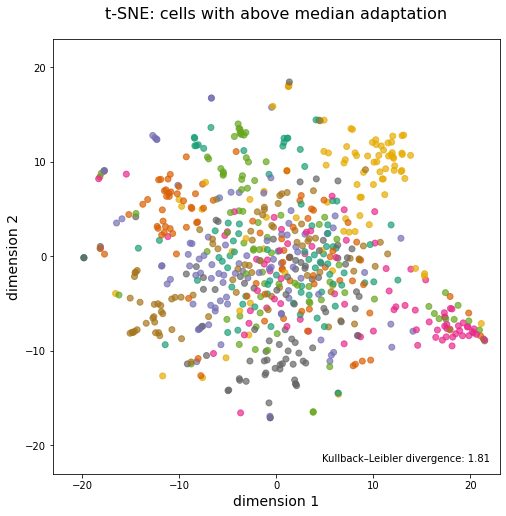

In [ ]:
from matplotlib.offsetbox import AnchoredText

fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(above_tsne_df.comp1, above_tsne_df.comp2, c = above_tsne_df.image_index, cmap = 'Dark2', alpha = 0.7)
figtitle = 't-SNE: cells with above median adaptation' 
plt.title(figtitle, fontsize=16, pad=20)
plt.xlabel('dimension 1', fontsize = 14)
plt.ylabel('dimension 2', fontsize = 14)
plt.xlim(-23,23)
plt.xticks(np.arange(-20, 20.1, step=10))
plt.ylim(-23,23)
plt.yticks(np.arange(-20, 20.1, step=10))

box_text = 'Kullback–Leibler divergence: ' + '{0:.2f}'.format(above_tsne.kl_divergence_)
text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='white', alpha=0.5);
ax.add_artist(text_box)

# print("KL Divergence:", above_tsne.kl_divergence_)
plt.savefig(figtitle + '.pdf', format='pdf')
from google.colab import files
files.download(figtitle + '.pdf')

In [ ]:
below_tsne = TSNE(n_components=2, init='random',
                         random_state=0, perplexity=30, n_iter = 3000)


below_tsne_fit = below_tsne.fit_transform(below_cells_features)

#put the labels (image index and repeat number) back for plotting
below_tsne_df = pd.DataFrame(data = below_tsne_fit
             , columns = ['comp1', 'comp2'])

below_tsne_df = pd.concat([below_tsne_df, below_cells_df[['image_index', 'repeat_number']].reset_index()], axis = 1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

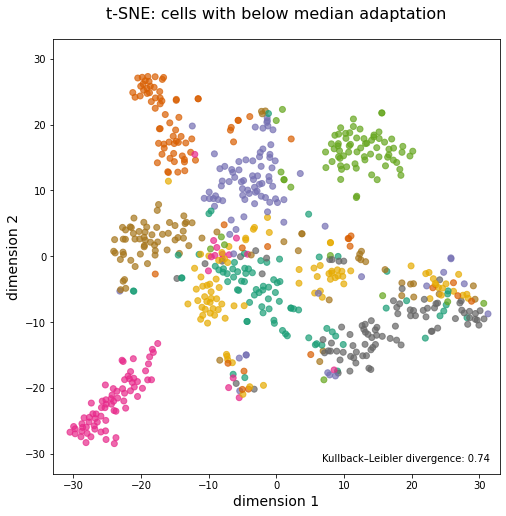

In [ ]:
from matplotlib.offsetbox import AnchoredText

fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(below_tsne_df.comp1, below_tsne_df.comp2, c = below_tsne_df.image_index, cmap = 'Dark2', alpha = 0.7)
figtitle = 't-SNE: cells with below median adaptation' 
plt.title(figtitle, fontsize=16, pad=20)
plt.xlabel('dimension 1', fontsize = 14)
plt.ylabel('dimension 2', fontsize = 14)

axis_max = 33
plt.xlim(-axis_max,axis_max)
plt.xticks(np.arange(-30, axis_max+0.1, step=10))
plt.ylim(-axis_max,axis_max)
plt.yticks(np.arange(-30, axis_max+0.1, step=10))

box_text = 'Kullback–Leibler divergence: ' + '{0:.2f}'.format(below_tsne.kl_divergence_)
text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='white', alpha=0.5);
ax.add_artist(text_box)

# print("KL Divergence:", below_tsne.kl_divergence_)
plt.savefig(figtitle + '.pdf', format='pdf')
from google.colab import files
files.download(figtitle + '.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

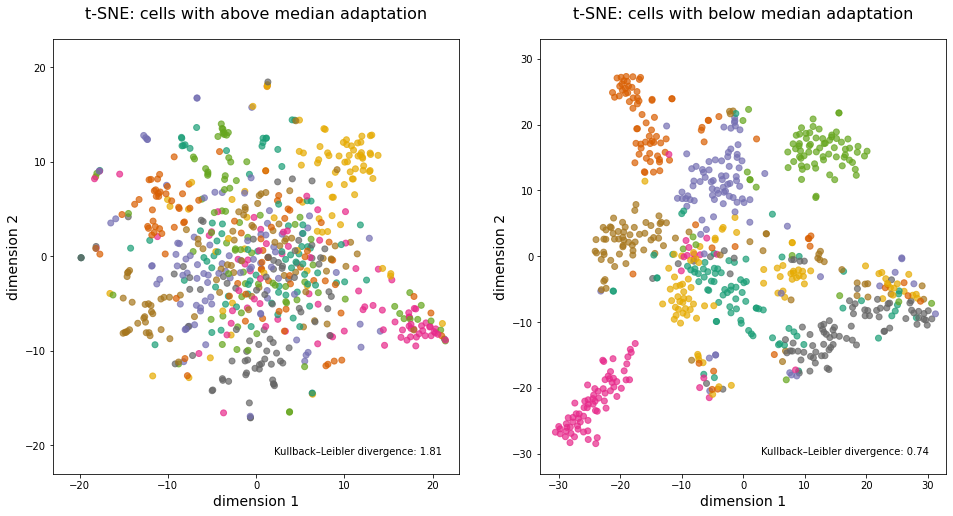

In [ ]:
from matplotlib.offsetbox import AnchoredText

fig, [ax0, ax1] = plt.subplots(nrows=1, ncols=2, figsize = (16,8))

ax0.scatter(above_tsne_df.comp1, above_tsne_df.comp2, c = above_tsne_df.image_index, cmap = 'Dark2', alpha = 0.7)
figtitle = 't-SNE: cells with above median adaptation' 
ax0.set_title(figtitle, fontsize=16, pad=20)
ax0.set_xlabel('dimension 1', fontsize = 14)
ax0.set_ylabel('dimension 2', fontsize = 14)
ax0.set_xlim(-23,23)
ax0.set_xticks(np.arange(-20, 20.1, step=10))
ax0.set_ylim(-23,23)
ax0.set_yticks(np.arange(-20, 20.1, step=10))
box_text = 'Kullback–Leibler divergence: ' + '{0:.2f}'.format(above_tsne.kl_divergence_)
ax0.text(0.75, 0.05, box_text, horizontalalignment='center', verticalalignment='center', transform=ax0.transAxes)
ax.add_artist(text_box)

ax1.scatter(below_tsne_df.comp1, below_tsne_df.comp2, c = below_tsne_df.image_index, cmap = 'Dark2', alpha = 0.7)
figtitle = 't-SNE: cells with below median adaptation' 
ax1.set_title(figtitle, fontsize=16, pad=20)
ax1.set_xlabel('dimension 1', fontsize = 14)
ax1.set_ylabel('dimension 2', fontsize = 14)
axis_max = 33
ax1.set_xlim(-axis_max,axis_max)
ax1.set_xticks(np.arange(-30, axis_max+0.1, step=10))
ax1.set_ylim(-axis_max,axis_max)
ax1.set_yticks(np.arange(-30, axis_max+0.1, step=10))
box_text = 'Kullback–Leibler divergence: ' + '{0:.2f}'.format(below_tsne.kl_divergence_)
ax1.text(0.75, 0.05, box_text, horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
ax.add_artist(text_box)

suptitle = 't-SNE'
plt.savefig(suptitle + '.pdf', format='pdf')
from google.colab import files
files.download(suptitle + '.pdf')

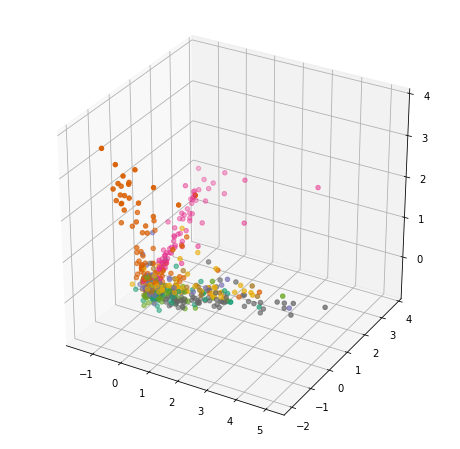

In [ ]:
below_pca = PCA(n_components = 3)
#transform all data based on this fit 
below_principal_pcs = below_pca.fit_transform(below_cells_features)

#put the labels (image index and repeat number) back for plotting
below_principal_df = pd.DataFrame(data =below_principal_pcs
             , columns = ['pc1', 'pc2', 'pc3'])
below_principal_df = pd.concat([below_principal_df, trials_to_keep[['image_index', 'repeat_number']].reset_index()], axis = 1)



fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(below_principal_df.pc1, below_principal_df.pc2, below_principal_df.pc3, c = below_principal_df.image_index, cmap = 'Dark2' )
#ax.view_init(60, 30) 



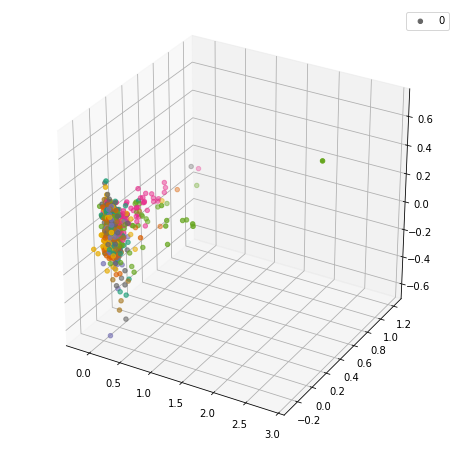

In [ ]:
above_pca = PCA(n_components = 3)
#transform all data based on this fit 
above_principal_pcs = above_pca.fit_transform(above_cells_features)

#put the labels (image index and repeat number) back for plotting
above_principal_df = pd.DataFrame(data =above_principal_pcs
             , columns = ['pc1', 'pc2', 'pc3'])
above_principal_df = pd.concat([above_principal_df, trials_to_keep[['image_index', 'repeat_number']].reset_index()], axis = 1)



fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(above_principal_df.pc1, above_principal_df.pc2,above_principal_df.pc3, c = above_principal_df.image_index, cmap = 'Dark2')
ax.legend(range(8))
#ax.view_init(60, 30) 

In [ ]:
above_pca = PCA()
below_pca = PCA()

below_pcs = above_pca.fit_transform(above_cells_features)
above_pcs = below_pca.fit_transform(below_cells_features)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

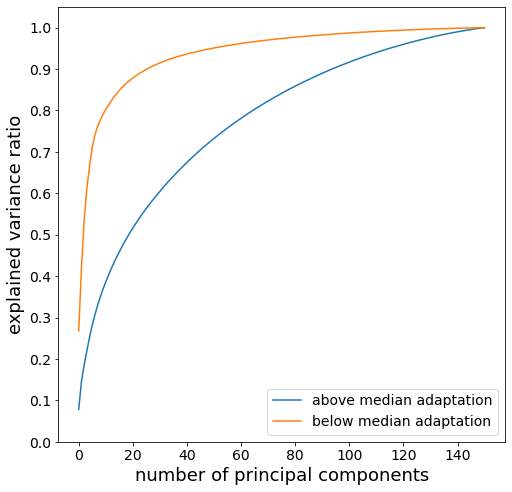

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(np.cumsum(above_pca.explained_variance_ratio_))
plt.plot(np.cumsum(below_pca.explained_variance_ratio_))

plt.xticks(fontsize=14)
plt.ylim(-0,1.05)
plt.yticks(np.arange(-0, 1.01, step=0.1), fontsize=14)
plt.legend(['above median adaptation', 'below median adaptation'], loc='lower right', 
           fontsize=14)
# plt.grid('minor')

plt.xlabel('number of principal components', fontsize=18)
plt.ylabel('explained variance ratio', fontsize=18);
figtitle = 'PCA: cells with above or below median adaptation'
# plt.title(figtitle, fontsize=16, pad=20);
plt.savefig(figtitle + '.pdf', format='pdf')
from google.colab import files
files.download(figtitle + '.pdf')

## Use unadapted trials

Now, we split the neurons by whether adaptation magnitude is above or below the median. 

Median adaptation magnitude:  0.6380086161047156


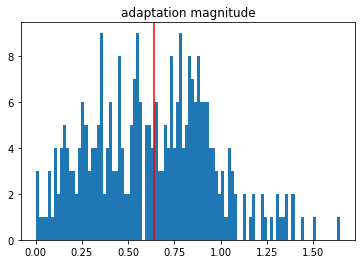

In [ ]:
plt.hist(adaptation_magnitude_df.abs_adaptation, bins = 100)
plt.title("adaptation magnitude")
median_adaptation = adaptation_magnitude_df.abs_adaptation.median()
print("Median adaptation magnitude: ", median_adaptation)

above_adapted_cells = adaptation_magnitude_df[adaptation_magnitude_df.abs_adaptation > median_adaptation ]
below_adapted_cells = adaptation_magnitude_df[adaptation_magnitude_df.abs_adaptation <= median_adaptation ]

plt.axvline(median_adaptation, color = 'red')

In [ ]:
trial0 = trials_to_keep[trials_to_keep.repeat_number == 0]
trial1 = trials_to_keep[trials_to_keep.repeat_number == 1]

In [ ]:
above_cells_df = trial0[above_adapted_cells.neuron_id.tolist()+non_neuron_columms]
below_cells_df = trial0[below_adapted_cells.neuron_id.tolist() + non_neuron_columms]

above_cells_features = trial0[above_adapted_cells.neuron_id.tolist()]
below_cells_features = trial0[below_adapted_cells.neuron_id.tolist()]

In [ ]:
above_tsne = TSNE(n_components=2, init='random',
                         random_state=0, perplexity=30, n_iter = 3000)


above_tsne_fit = above_tsne.fit_transform(above_cells_features)

#put the labels (image index and repeat number) back for plotting
above_tsne_df = pd.DataFrame(data = above_tsne_fit
             , columns = ['comp1', 'comp2'])

above_tsne_df = pd.concat([above_tsne_df, above_cells_df[['image_index', 'repeat_number']].reset_index()], axis = 1)

KL Divergence: 1.2851800918579102


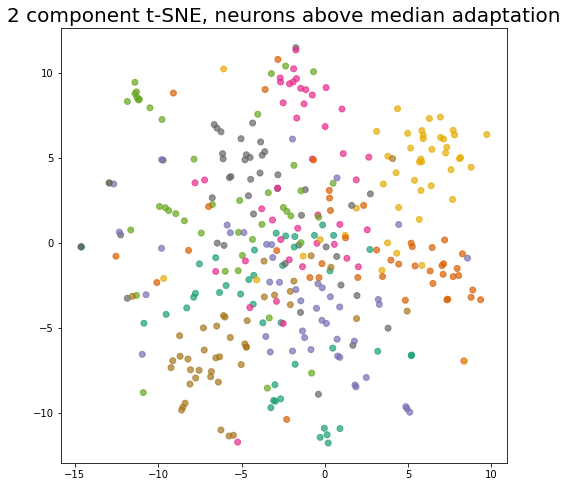

In [ ]:
#plot
plt.figure(figsize = (8,8))
plt.title('2 component t-SNE, neurons above median adaptation', fontsize = 20)
plt.scatter(above_tsne_df.comp1, above_tsne_df.comp2, c = above_tsne_df.image_index, cmap = 'Dark2', alpha = 0.7)

print("KL Divergence:", above_tsne.kl_divergence_)

In [ ]:
below_tsne = TSNE(n_components=2, init='random',
                         random_state=0, perplexity=30, n_iter = 3000)


below_tsne_fit = below_tsne.fit_transform(below_cells_features)

#put the labels (image index and repeat number) back for plotting
below_tsne_df = pd.DataFrame(data = below_tsne_fit
             , columns = ['comp1', 'comp2'])

below_tsne_df = pd.concat([below_tsne_df, below_cells_df[['image_index', 'repeat_number']].reset_index()], axis = 1)

KL divergence 0.6128464937210083


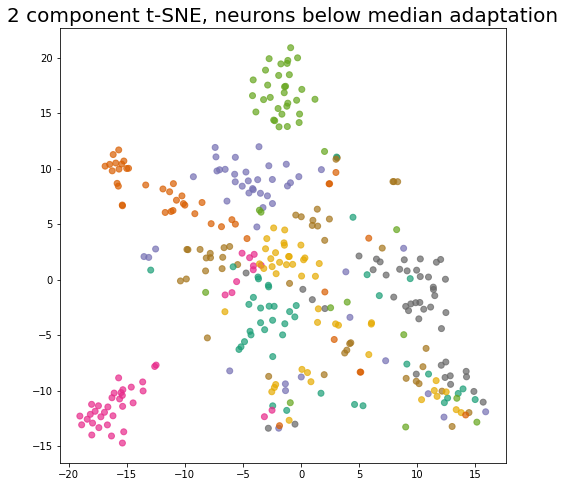

In [ ]:
#plot
plt.figure(figsize = (8,8))
plt.title('2 component t-SNE, neurons below median adaptation', fontsize = 20)
plt.scatter(below_tsne_df.comp1, below_tsne_df.comp2, c = below_tsne_df.image_index, cmap = 'Dark2', alpha = 0.7)

print("KL divergence", below_tsne.kl_divergence_)

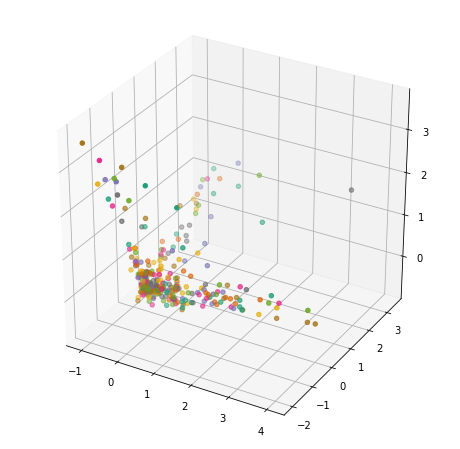

In [ ]:
below_pca = PCA(n_components = 3)
#transform all data based on this fit 
below_principal_pcs = below_pca.fit_transform(below_cells_features)

#put the labels (image index and repeat number) back for plotting
below_principal_df = pd.DataFrame(data =below_principal_pcs
             , columns = ['pc1', 'pc2', 'pc3'])
below_principal_df = pd.concat([below_principal_df, trials_to_keep[['image_index', 'repeat_number']].reset_index()], axis = 1)



fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(below_principal_df.pc1, below_principal_df.pc2, below_principal_df.pc3, c = below_principal_df.image_index, cmap = 'Dark2' )
#ax.view_init(60, 30) 



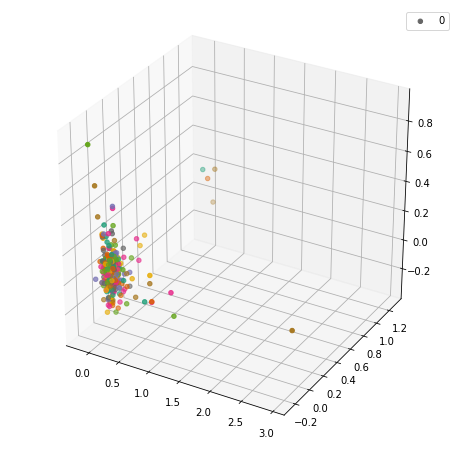

In [ ]:
above_pca = PCA(n_components = 3)
#transform all data based on this fit 
above_principal_pcs = above_pca.fit_transform(above_cells_features)

#put the labels (image index and repeat number) back for plotting
above_principal_df = pd.DataFrame(data =above_principal_pcs
             , columns = ['pc1', 'pc2', 'pc3'])
above_principal_df = pd.concat([above_principal_df, trials_to_keep[['image_index', 'repeat_number']].reset_index()], axis = 1)



fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(above_principal_df.pc1, above_principal_df.pc2,above_principal_df.pc3, c = above_principal_df.image_index, cmap = 'Dark2')
ax.legend(range(8))
#ax.view_init(60, 30) 

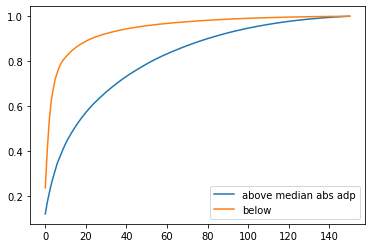

In [ ]:
above_pca = PCA()
below_pca = PCA()


above_pcs = above_pca.fit_transform(above_cells_features)
below_pcs = below_pca.fit_transform(below_cells_features)

plt.plot(np.cumsum(above_pca.explained_variance_ratio_))
plt.plot(np.cumsum(below_pca.explained_variance_ratio_))
plt.legend(["above median abs adp", "below"])

## Use adapted trials

In [ ]:
above_cells_df = trial1[above_adapted_cells.neuron_id.tolist()+non_neuron_columms]
below_cells_df = trial1[below_adapted_cells.neuron_id.tolist() + non_neuron_columms]

above_cells_features = trial1[above_adapted_cells.neuron_id.tolist()]
below_cells_features = trial1[below_adapted_cells.neuron_id.tolist()]

In [ ]:
above_tsne = TSNE(n_components=2, init='random',
                         random_state=0, perplexity=30, n_iter = 3000)


above_tsne_fit = above_tsne.fit_transform(above_cells_features)

#put the labels (image index and repeat number) back for plotting
above_tsne_df = pd.DataFrame(data = above_tsne_fit
             , columns = ['comp1', 'comp2'])

above_tsne_df = pd.concat([above_tsne_df, above_cells_df[['image_index', 'repeat_number']].reset_index()], axis = 1)

KL Divergence: 1.3554184436798096


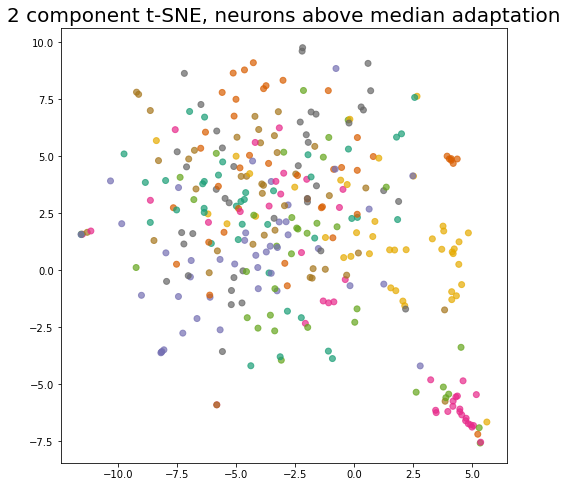

In [ ]:
#plot
plt.figure(figsize = (8,8))
plt.title('2 component t-SNE, neurons above median adaptation', fontsize = 20)
plt.scatter(above_tsne_df.comp1, above_tsne_df.comp2, c = above_tsne_df.image_index, cmap = 'Dark2', alpha = 0.7)

print("KL Divergence:", above_tsne.kl_divergence_)

In [ ]:
below_tsne = TSNE(n_components=2, init='random',
                         random_state=0, perplexity=30, n_iter = 3000)


below_tsne_fit = below_tsne.fit_transform(below_cells_features)

#put the labels (image index and repeat number) back for plotting
below_tsne_df = pd.DataFrame(data = below_tsne_fit
             , columns = ['comp1', 'comp2'])

below_tsne_df = pd.concat([below_tsne_df, below_cells_df[['image_index', 'repeat_number']].reset_index()], axis = 1)

KL divergence 0.5163612365722656


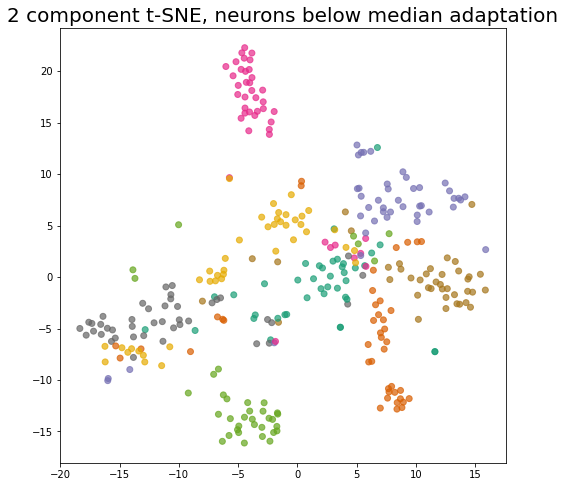

In [ ]:
#plot
plt.figure(figsize = (8,8))
plt.title('2 component t-SNE, neurons below median adaptation', fontsize = 20)
plt.scatter(below_tsne_df.comp1, below_tsne_df.comp2, c = below_tsne_df.image_index, cmap = 'Dark2', alpha = 0.7)

print("KL divergence", below_tsne.kl_divergence_)

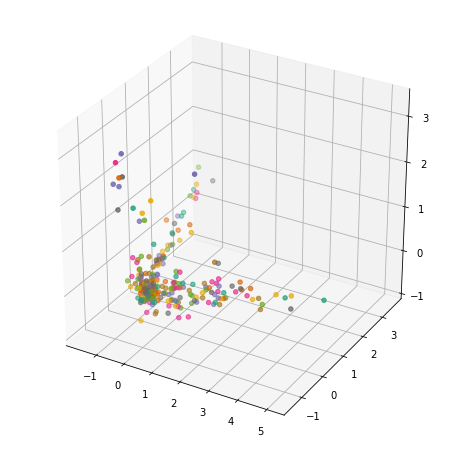

In [ ]:
below_pca = PCA(n_components = 3)
#transform all data based on this fit 
below_principal_pcs = below_pca.fit_transform(below_cells_features)

#put the labels (image index and repeat number) back for plotting
below_principal_df = pd.DataFrame(data =below_principal_pcs
             , columns = ['pc1', 'pc2', 'pc3'])
below_principal_df = pd.concat([below_principal_df, trials_to_keep[['image_index', 'repeat_number']].reset_index()], axis = 1)



fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(below_principal_df.pc1, below_principal_df.pc2, below_principal_df.pc3, c = below_principal_df.image_index, cmap = 'Dark2' )
#ax.view_init(60, 30) 



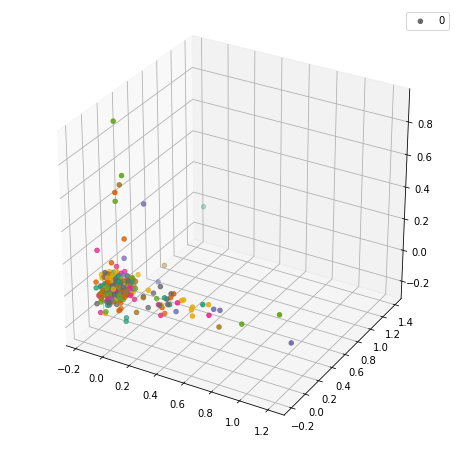

In [ ]:
above_pca = PCA(n_components = 3)
#transform all data based on this fit 
above_principal_pcs = above_pca.fit_transform(above_cells_features)

#put the labels (image index and repeat number) back for plotting
above_principal_df = pd.DataFrame(data =above_principal_pcs
             , columns = ['pc1', 'pc2', 'pc3'])
above_principal_df = pd.concat([above_principal_df, trials_to_keep[['image_index', 'repeat_number']].reset_index()], axis = 1)



fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(above_principal_df.pc1, above_principal_df.pc2,above_principal_df.pc3, c = above_principal_df.image_index, cmap = 'Dark2')
ax.legend(range(8))
#ax.view_init(60, 30) 

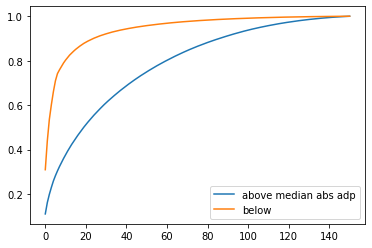

In [ ]:
above_pca = PCA()
below_pca = PCA()


above_pcs = above_pca.fit_transform(above_cells_features)
below_pcs = below_pca.fit_transform(below_cells_features)

plt.plot(np.cumsum(above_pca.explained_variance_ratio_))
plt.plot(np.cumsum(below_pca.explained_variance_ratio_))
plt.legend(["above median abs adp", "below"])

# Nonlinear things that didn't work

Yet more nonlinear dimension detections: Ila Fiete's thing

In [ ]:
#returns a matrix d_mat whose [i,j] entry is the distance between row i and row j or A
def distance_mat(A):
  (m, n) = A.shape
  d_mat = np.zeros((m, m))
  for i in range(m):
    for j in range(i,m):
      d_mat[j,i] = d_mat[i,j] = np.sqrt(np.sum((A[i, :]- A[j, :])**2))
  return d_mat

In [ ]:
A2 = np.random.rand(100,2) @ np.random.rand(2,100)
A1 = np.random.rand(100,1) @ np.random.rand(1,100)


D1 = distance_mat(A1) 
D2 = distance_mat(A2) 


In [ ]:
def n_points_in_ball(D, i, t):
  return np.sum(D[i,: ] < t)

In [ ]:
def sliding_threshold(D,i,T):
  return [n_points_in_ball(D, i, t) for t in T]

In [ ]:
def mean_sliding_threshold(D,L,T):
  total = np.zeros_like(T)
  for i in L:
    total += sliding_threshold(D,i,T)
  return total/len(L)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


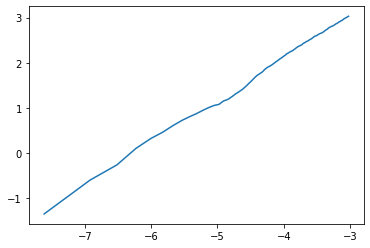

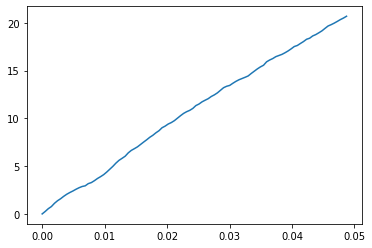

In [ ]:
T = np.linspace(0,A1.max()/20, 100 )
plt.plot(np.log(T), np.log(mean_sliding_threshold(A1,range(100),T)))
plt.figure()
plt.plot(T, mean_sliding_threshold(A1,range(100),T))

array([[2.29832424]])

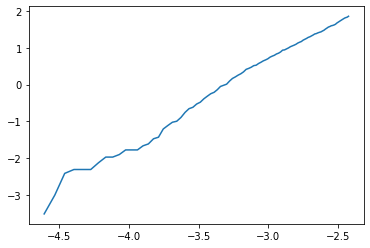

In [ ]:
T = np.linspace(.01,A2.max()/20, 100 )
plt.plot(np.log(T), np.log(mean_sliding_threshold(A2,range(100),T)))

reg = LinearRegression().fit(np.log(T).reshape(-1,1), np.log( mean_sliding_threshold(A2 ,range(100),T)).reshape(-1,1))
reg.coef_


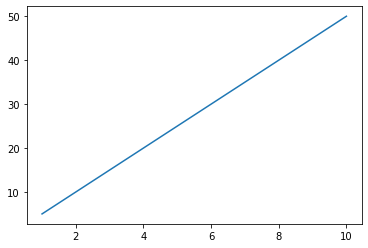

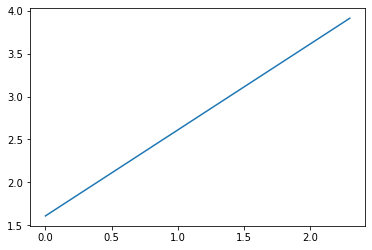

In [ ]:
x = np.linspace(1,10, 100)
y = 5*x**1
plt.plot(x,y)
plt.figure()
plt.plot(np.log(x), np.log(y))